- Reference
  - https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

In [1]:
import os

In [2]:
os.makedirs('data/images', exist_ok=True)

In [3]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

In [17]:
class GAN():
    def __init__(self):
        self.history = pd.DataFrame({}, columns=['d_loss', 'acc', 'g_loss'])

        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        self.generator = self.build_generator()

        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.summary()
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):
        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):
        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        print(datetime.datetime.now().isoformat(), 'Epoch Start')

        for epoch in range(epochs):
            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid)

            # print (datetime.datetime.now().isoformat(), "%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            self.history = self.history.append({'d_loss': d_loss[0], 'acc': d_loss[1], 'g_loss': g_loss}, ignore_index=True)

            if epoch % sample_interval == 0:
                print (datetime.datetime.now().isoformat(), "%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)
                
        print(datetime.datetime.now().isoformat(), 'Epoch End')

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0

        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1

        fig.savefig('data/images/%d.png' % epoch)
        plt.close()

    def plot_hisotry(self, columns=[]):
        if len(columns) == 0:
            columns = ['d_loss', 'acc', 'g_loss']
        self.history[columns].plot()

In [18]:
gan = GAN()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

In [19]:
gan.train(epochs=300, batch_size=32, sample_interval=50)

2020-07-19T22:57:01.538374 Epoch Start
2020-07-19T22:57:02.601774 0 [D loss: 0.671119, acc.: 48.44%] [G loss: 0.358629]
2020-07-19T22:57:05.233765 50 [D loss: 0.014089, acc.: 100.00%] [G loss: 4.067346]
2020-07-19T22:57:08.138882 100 [D loss: 0.009158, acc.: 100.00%] [G loss: 5.005742]
2020-07-19T22:57:10.686726 150 [D loss: 0.070631, acc.: 98.44%] [G loss: 3.439389]
2020-07-19T22:57:13.396414 200 [D loss: 0.219585, acc.: 90.62%] [G loss: 2.816328]
2020-07-19T22:57:16.006100 250 [D loss: 0.563454, acc.: 65.62%] [G loss: 1.694025]
2020-07-19T22:57:18.732528 Epoch End


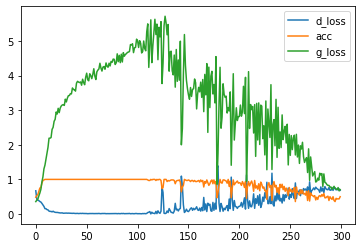

In [20]:
gan.plot_hisotry()

In [21]:
gan.train(epochs=700, batch_size=32, sample_interval=50)

2020-07-19T22:58:16.215019 Epoch Start
2020-07-19T22:58:16.271691 0 [D loss: 0.722929, acc.: 48.44%] [G loss: 0.675267]
2020-07-19T22:58:18.851647 50 [D loss: 0.645637, acc.: 50.00%] [G loss: 0.665819]
2020-07-19T22:58:21.448767 100 [D loss: 0.619971, acc.: 50.00%] [G loss: 0.757004]
2020-07-19T22:58:24.349312 150 [D loss: 0.643598, acc.: 65.62%] [G loss: 0.733123]
2020-07-19T22:58:26.946243 200 [D loss: 0.606471, acc.: 62.50%] [G loss: 0.834060]
2020-07-19T22:58:29.537946 250 [D loss: 0.628377, acc.: 53.12%] [G loss: 0.766003]
2020-07-19T22:58:32.285352 300 [D loss: 0.628542, acc.: 64.06%] [G loss: 0.840342]
2020-07-19T22:58:34.886814 350 [D loss: 0.665834, acc.: 57.81%] [G loss: 0.859120]
2020-07-19T22:58:37.474491 400 [D loss: 0.614554, acc.: 68.75%] [G loss: 0.809765]
2020-07-19T22:58:40.298246 450 [D loss: 0.628811, acc.: 59.38%] [G loss: 0.876356]
2020-07-19T22:58:42.882260 500 [D loss: 0.675053, acc.: 59.38%] [G loss: 0.791829]
2020-07-19T22:58:45.486840 550 [D loss: 0.588672, a

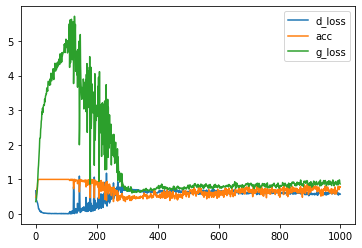

In [23]:
gan.plot_hisotry()

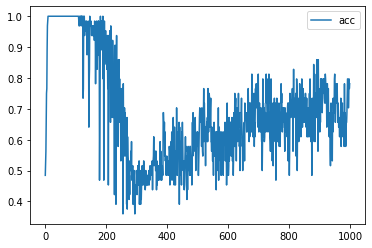

In [24]:
gan.plot_hisotry(['acc'])